# 🏀 NBA Offensive Player Archetypes (2024-25 NBA Regular Season)

## 🔍 Goal
Use season-long NBA player data to cluster players into offensive archetypes, enabling cross-industry demonstration of unsupervised learning, data wrangling, and storytelling with real-world data.

## 💼 Transferable Skills
- API data acquisition and pipeline construction
- Feature selection and preprocessing
- Dimensionality reduction (PCA/t-SNE)
- Clustering (KMeans, Silhouette Score)
- Visual storytelling and interpretation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install nba_api --quiet

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nba_api.stats.static import players
from nba_api.stats.endpoints import playerdashboardbygeneralsplits
from nba_api.stats.endpoints import playercareerstats
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 11.1 MB/s eta 0:00:00


In [2]:
# Get all active NBA players
active_players = players.get_active_players()
print(f"Total active players: {len(active_players)}")

Total active players: 572


In [3]:
def get_player_stats(player_id):
    try:
        stats = playercareerstats.PlayerCareerStats(player_id=player_id)
        df = stats.get_data_frames()[0]
        df = df[df['SEASON_ID'] == '2024-25']
        return df
    except:
        return pd.DataFrame()

In [4]:
all_stats = []

for p in active_players:
    pid = p['id']
    name = p['full_name']
    df = get_player_stats(pid)
    
    if not df.empty:
        df['PLAYER_ID'] = pid
        df['PLAYER_NAME'] = name
        all_stats.append(df)

    time.sleep(0.6)  # Delay to avoid API limits

In [5]:
nba_df = pd.concat(all_stats, ignore_index=True)
print(nba_df.shape)
print(nba_df.columns)

(732, 28)
Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLAYER_NAME'],
      dtype='object')


In [6]:
nba_df

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLAYER_NAME
0,1630173,2024-25,00,1610612752,NYK,25.0,57,10,1170.0,164,...,101,216,317,55,47,42,45,81,379,Precious Achiuwa
1,203500,2024-25,00,1610612745,HOU,31.0,58,3,794.0,91,...,166,161,327,66,22,28,54,60,225,Steven Adams
2,1628389,2024-25,00,1610612748,MIA,27.0,78,78,2674.0,540,...,185,564,749,337,98,53,161,162,1410,Bam Adebayo
3,1630534,2024-25,00,1610612761,TOR,24.0,64,45,1739.0,266,...,61,181,242,98,58,30,54,125,667,Ochai Agbaji
4,1630583,2024-25,00,1610612763,MEM,24.0,65,16,1660.0,313,...,94,322,416,188,52,29,71,76,811,Santi Aldama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,1629027,2024-25,00,1610612737,ATL,26.0,76,76,2739.0,566,...,36,200,236,880,91,12,355,145,1841,Trae Young
728,1627826,2024-25,00,1610612746,LAC,28.0,80,80,2624.0,592,...,300,710,1010,214,55,90,127,168,1340,Ivica Zubac
729,1641783,2024-25,00,1610612753,ORL,23.0,74,38,1629.0,199,...,73,172,245,113,33,18,56,94,533,Tristan da Silva
730,1628427,2024-25,00,1610612743,DEN,28.0,13,0,136.0,10,...,6,26,32,9,3,2,11,10,24,Vlatko Čančar


In [7]:
print("Unique PLAYER_NAMEs:", nba_df['PLAYER_NAME'].nunique())
print("Unique PLAYER_IDs:", nba_df['PLAYER_ID'].nunique())

Unique PLAYER_NAMEs: 566
Unique PLAYER_IDs: 566


In [8]:
player_counts = nba_df['PLAYER_ID'].value_counts()
multi_team_players = player_counts[player_counts > 1]
print("Players with multiple entries:", len(multi_team_players))

Players with multiple entries: 81


In [9]:
# Get all rows for players who appeared on multiple teams
multi_team_ids = multi_team_players.index
traded_players_df = nba_df[nba_df['PLAYER_ID'].isin(multi_team_ids)]

# Sort for cleaner viewing
traded_players_df1 = traded_players_df.sort_values(by=['PLAYER_NAME', 'TEAM_ABBREVIATION'])

# Display
traded_players_df1

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLAYER_NAME
304,1642358,2024-25,00,1610612749,MIL,20.0,7,0,44.0,8,...,0,7,7,7,1,0,4,0,20,AJ Johnson
306,1642358,2024-25,00,0,TOT,20.0,29,11,638.0,82,...,8,51,59,76,12,3,35,50,220,AJ Johnson
305,1642358,2024-25,00,1610612764,WAS,20.0,22,11,595.0,74,...,8,44,52,69,11,3,31,50,200,AJ Johnson
370,203458,2024-25,00,1610612747,LAL,31.0,10,4,122.0,10,...,13,18,31,8,1,3,9,21,22,Alex Len
369,203458,2024-25,00,1610612758,SAC,31.0,36,3,258.0,22,...,25,39,64,30,8,18,11,35,52,Alex Len
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,1628380,2024-25,00,1610612759,SAS,27.0,36,4,425.0,61,...,38,63,101,52,14,15,23,70,167,Zach Collins
133,1628380,2024-25,00,0,TOT,27.0,64,12,977.0,153,...,102,186,288,111,29,29,60,132,407,Zach Collins
358,203897,2024-25,00,1610612741,CHI,30.0,42,42,1432.0,363,...,12,190,202,189,39,10,121,64,1007,Zach LaVine
359,203897,2024-25,00,1610612758,SAC,30.0,32,32,1170.0,262,...,10,103,113,121,19,2,87,57,717,Zach LaVine


In [10]:
# Keep all "TOT" rows for players who have been traded mid-season
tot_df = nba_df[nba_df['TEAM_ABBREVIATION'] == 'TOT']

# B: For players who were not traded, keep their entry
non_tot_df = nba_df[nba_df['TEAM_ABBREVIATION'] != 'TOT']
non_tot_df = non_tot_df[~non_tot_df['PLAYER_ID'].isin(tot_df['PLAYER_ID'])]

# Combine cleaned data
nba_cleaned = pd.concat([tot_df, non_tot_df], ignore_index=True)
print("Shape after deduplication:", nba_cleaned.shape)

Shape after deduplication: (566, 28)


In [11]:
nba_cleaned

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLAYER_NAME
0,203937,2024-25,00,0,TOT,31.0,61,4,1002.0,142,...,53,153,206,145,40,33,37,81,357,Kyle Anderson
1,1628963,2024-25,00,0,TOT,26.0,31,2,265.0,55,...,38,46,84,11,9,8,12,18,136,Marvin Bagley III
2,1631116,2024-25,00,0,TOT,22.0,24,0,107.0,19,...,5,20,25,3,3,2,5,7,53,Patrick Baldwin Jr.
3,1628964,2024-25,00,0,TOT,26.0,32,2,413.0,52,...,32,113,145,18,9,31,20,56,138,Mo Bamba
4,1630699,2024-25,00,0,TOT,24.0,35,0,156.0,27,...,11,33,44,11,4,1,15,14,79,MarJon Beauchamp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1629027,2024-25,00,1610612737,ATL,26.0,76,76,2739.0,566,...,36,200,236,880,91,12,355,145,1841,Trae Young
562,1627826,2024-25,00,1610612746,LAC,28.0,80,80,2624.0,592,...,300,710,1010,214,55,90,127,168,1340,Ivica Zubac
563,1641783,2024-25,00,1610612753,ORL,23.0,74,38,1629.0,199,...,73,172,245,113,33,18,56,94,533,Tristan da Silva
564,1628427,2024-25,00,1610612743,DEN,28.0,13,0,136.0,10,...,6,26,32,9,3,2,11,10,24,Vlatko Čančar


## 🧹 Data Cleaning: Handling Traded Players with Duplicate Rows
The raw player stats dataset pulled from the NBA API includes multiple rows per player if they were traded mid-season — one for each team played on, plus a "TOT" row that aggregates season totals across all teams.

To ensure one unique row per player for clustering and modeling, I implemented the following logic:
* If a player has a "TOT" (Total) row, I kept only the TOT version, which represents their full season stats.
* If a player does not have a TOT row (i.e., stayed with one team), I kept that single row as-is.

This approach reduced duplication and ensured each player is represented accurately across the dataset.

This step is critical to:
* Maintain data integrity by avoiding double-counting players.
* Ensure clustering models are trained on complete, not fragmented, player profiles.
* Mirror real-world analytics practices, where entities like customers or employees are often tracked across multiple contexts but need to be aggregated for analysis.

## 🧪 Feature Engineering: Crafting Metrics That Matter

Before diving into modeling or visualization, it's essential to ensure that the data captures meaningful basketball insights.

### 🎯 Why Feature Engineering?
Rather than jumping straight into machine learning, this step focuses on transforming raw box score data into **interpretable performance metrics** that more accurately reflect a player's offensive profile. These features help us move beyond basic stats like "points per game" and instead assess **how** a player generates offense — whether through volume, efficiency, passing, or shot selection.

This mirrors real-world practices in sports analytics, where the goal is often to build **domain-specific indicators** that can:
- 📊 Improve clustering quality (e.g., offensive archetypes)
- 🧠 Enhance model interpretability for non-technical stakeholders
- 🔁 Scale across future seasons or players

### 🛠️ Features I Engineered:
- `PTS_per36` – Points scored per 36 minutes
- `AST_per36` – Assists per 36 minutes
- `REB_per36` – Rebounds per 36 minutes
- `FG3M_per36` – Made 3-pointers per 36 minutes
- `TOV_per36` – Turnovers per 36 minutes
- `FGA_per36` – Shot volume per 36 minutes
- `MPG` – Minutes per game
- `AST_to_TOV` – Playmaking efficiency (AST ÷ TOV)
- `3PAr` – Three-point attempt rate (3PA ÷ FGA)
- `TS_proxy` – Simple scoring efficiency (PTS ÷ FGA)
- `USG_proxy` – Offensive involvement (FGA + TOV) ÷ MIN
- `REB_rate` – Total rebounds per minute (REB ÷ MIN)
- `EFF_score` – Crude player impact estimate: (PTS + REB + AST - TOV) ÷ MIN

These engineered features serve as the foundation for clustering and player segmentation, offering richer context than raw box score totals.

In [12]:
# Avoid division by zero for MIN
nba_c = nba_cleaned[nba_cleaned['MIN'] > 0].copy()

# Per-36 minute scoring and stats
nba_c['PTS_per36'] = (nba_c['PTS'] / nba_c['MIN']) * 36
nba_c['AST_per36'] = (nba_c['AST'] / nba_c['MIN']) * 36
nba_c['REB_per36'] = (nba_c['REB'] / nba_c['MIN']) * 36
nba_c['FG3M_per36'] = (nba_c['FG3M'] / nba_c['MIN']) * 36
nba_c['TOV_per36'] = (nba_c['TOV'] / nba_c['MIN']) * 36
nba_c['FGA_per36'] = (nba_c['FGA'] / nba_c['MIN']) * 36
nba_c['MPG'] = (nba_c['MIN'] / nba_c['GP'])
nba_c['AST_TOV_ratio'] = (nba_c['AST'] / nba_c['TOV'])
nba_c['3PAr'] = (nba_c['FG3A'] / nba_c['FGA'])
nba_c['TS_Proxy'] = (nba_c['PTS'] / nba_c['FGA'])
nba_c['USG_Proxy'] = ((nba_c['FGA'] + nba_c['TOV']) / nba_c['MIN'])
nba_c['REB_rate'] = (nba_c['REB'] / nba_c['MIN'])
nba_c['EFF_score'] = ((nba_c['PTS'] + nba_c['REB'] - nba_c['TOV']) / nba_c['MIN'])
print(nba_c.columns)

Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLAYER_NAME', 'PTS_per36', 'AST_per36',
       'REB_per36', 'FG3M_per36', 'TOV_per36', 'FGA_per36', 'MPG',
       'AST_TOV_ratio', '3PAr', 'TS_Proxy', 'USG_Proxy', 'REB_rate',
       'EFF_score'],
      dtype='object')


In [13]:
nba_cleaned.shape, nba_cleaned.columns[-10:]

((566, 28),
 Index(['OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
        'PLAYER_NAME'],
       dtype='object'))

In [14]:
nba_c

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FG3M_per36,TOV_per36,FGA_per36,MPG,AST_TOV_ratio,3PAr,TS_Proxy,USG_Proxy,REB_rate,EFF_score
0,203937,2024-25,00,0,TOT,31.0,61,4,1002.0,142,...,0.898204,1.329341,10.886228,16.426230,3.918919,0.231023,1.178218,0.339321,0.205589,0.524950
1,1628963,2024-25,00,0,TOT,26.0,31,2,265.0,55,...,0.407547,1.630189,14.400000,8.548387,0.916667,0.179245,1.283019,0.445283,0.316981,0.784906
2,1631116,2024-25,00,0,TOT,22.0,24,0,107.0,19,...,4.373832,1.682243,11.775701,4.458333,0.600000,0.657143,1.514286,0.373832,0.233645,0.682243
3,1628964,2024-25,00,0,TOT,26.0,32,2,413.0,52,...,1.307506,1.743341,9.762712,12.906250,0.900000,0.482143,1.232143,0.319613,0.351090,0.636804
4,1630699,2024-25,00,0,TOT,24.0,35,0,156.0,27,...,2.307692,3.461538,15.000000,4.457143,0.733333,0.446154,1.215385,0.512821,0.282051,0.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1629027,2024-25,00,1610612737,ATL,26.0,76,76,2739.0,566,...,2.865279,4.665936,18.085433,36.039474,2.478873,0.466570,1.337936,0.631982,0.086163,0.628697
562,1627826,2024-25,00,1610612746,LAC,28.0,80,80,2624.0,592,...,0.000000,1.742378,12.923780,32.800000,1.685039,0.000000,1.422505,0.407393,0.384909,0.847180
563,1641783,2024-25,00,1610612753,ORL,23.0,74,38,1629.0,199,...,1.767956,1.237569,10.674033,22.013514,2.017857,0.494824,1.103520,0.330878,0.150399,0.443217
564,1628427,2024-25,00,1610612743,DEN,28.0,13,0,136.0,10,...,1.058824,2.911765,6.882353,10.461538,0.818182,0.576923,0.923077,0.272059,0.235294,0.330882


## 🔀 Segmentation: Starters vs. Bench Players

To account for the difference in context between high-minute starters and efficient-but-low-minute bench players, I created a `Bench_Role` feature:

- Players with **< 26 MPG** are labeled as `"Bench"`
- Players with **≥ 26 MPG** are labeled as `"Starters"`

I then split the dataset into two tables:
- `starters_df` – Players likely playing starter-level minutes
- `bench_df` – Players contributing in limited roles

This decision was based on the understanding that:
- Many "bench" players still play 22–25 minutes and close games.
- Some starters technically start but play under 20 minutes due to matchup-specific rotations or ceremonial purposes.
- A 26-minute cutoff better captures players with a consistent impact on the game flow.

This segmentation allows for **targeted player profiling**, where I can better assess archetypes relative to role expectations. It also mirrors real-world analysis in sports front offices, where player projections are role-specific.

In [15]:
nba_c['Bench_Role'] = nba_c['MPG'] < 26

In [16]:
starters_df = nba_c[nba_c['Bench_Role'] == False].copy()
bench_df = nba_c[nba_c['Bench_Role'] == True].copy()

print("Starters shape:", starters_df.shape)
print("Bench shape:", bench_df.shape)
print(nba_c.columns)

Starters shape: (162, 42)
Bench shape: (404, 42)
Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLAYER_NAME', 'PTS_per36', 'AST_per36',
       'REB_per36', 'FG3M_per36', 'TOV_per36', 'FGA_per36', 'MPG',
       'AST_TOV_ratio', '3PAr', 'TS_Proxy', 'USG_Proxy', 'REB_rate',
       'EFF_score', 'Bench_Role'],
      dtype='object')


In [17]:
features_to_cluster = [
    'PTS_per36', 'AST_per36', 'REB_per36', 'FG3M_per36', 'TOV_per36',
    'FGA_per36', 'AST_TOV_ratio', '3PAr', 'TS_Proxy', 'USG_Proxy',
    'REB_rate', 'EFF_score'
]

In [21]:
# Check for NaNs
print(bench_df[features_to_cluster].isna().sum())

# Check for inf or -inf
print(np.isinf(bench_df[features_to_cluster]).sum())

bench_df.dropna(subset=features_to_cluster, inplace=True)
bench_df.replace([np.inf, -np.inf], np.nan, inplace=True)

PTS_per36        0
AST_per36        0
REB_per36        0
FG3M_per36       0
TOV_per36        0
FGA_per36        0
AST_TOV_ratio    0
3PAr             0
TS_Proxy         0
USG_Proxy        0
REB_rate         0
EFF_score        0
dtype: int64
PTS_per36        0
AST_per36        0
REB_per36        0
FG3M_per36       0
TOV_per36        0
FGA_per36        0
AST_TOV_ratio    0
3PAr             0
TS_Proxy         0
USG_Proxy        0
REB_rate         0
EFF_score        0
dtype: int64


In [22]:
# Scale for starters
scaler_starters = StandardScaler()
starters_scaled = scaler_starters.fit_transform(starters_df[features_to_cluster])

# Scale for bench
scaler_bench = StandardScaler()
bench_scaled = scaler_bench.fit_transform(bench_df[features_to_cluster])

In [28]:
# KMeans for starters
kmeans_starters = KMeans(n_clusters=4, n_init=10, random_state=42)
starters_clusters = kmeans_starters.fit_predict(starters_scaled)
starters_df['Cluster'] = starters_clusters

# KMeans for bench
kmeans_bench = KMeans(n_clusters=3, n_init=10, random_state=42)
bench_clusters = kmeans_bench.fit_predict(bench_scaled)
bench_df['Cluster'] = bench_clusters

## 🧪 Standardization + Clustering

To ensure clustering algorithms treat each feature fairly, I standardized all role-based metrics (per 36 minutes, ratios, and proxies) to have a mean of 0 and a standard deviation of 1.

After that, I ran **K-Means clustering** separately on `starters` and `bench` players using 12 carefully engineered metrics. This helps create meaningful offensive archetypes based on player behavior and not just traditional box score totals.

Using `n_clusters=4` for starters/closers and `n_clusters=3` for bench role players allow for a balanced level of player grouping without overcomplicating interpretations.


In [29]:
# Create DataFrames for cluster centroid (interpreted scale)

# Starters
starters_c = pd.DataFrame(
    scaler_starters.inverse_transform(kmeans_starters.cluster_centers_),
    columns=features_to_cluster
)
starters_c['Cluster'] = starters_c.index

# Bench
bench_c = pd.DataFrame(
    scaler_bench.inverse_transform(kmeans_bench.cluster_centers_),
    columns=features_to_cluster
)
bench_c['Cluster'] = bench_c.index

# View profiles
print("Starter Cluster Profiles:")
display(starters_c.round(2))

print("\nBench Cluster Profiles:")
display(bench_c.round(2))

Starter Cluster Profiles:


,PTS_per36,AST_per36,REB_per36,FG3M_per36,TOV_per36,FGA_per36,AST_TOV_ratio,3PAr,TS_Proxy,USG_Proxy,REB_rate,EFF_score,Cluster
0,14.29,6.10,4.80,2.08,1.85,11.39,3.37,0.50,1.25,0.37,0.13,0.48,0
1,23.68,5.72,5.82,2.65,2.94,18.16,1.97,0.41,1.30,0.59,0.16,0.74,1
2,18.99,3.61,11.97,0.63,2.23,13.42,1.61,0.12,1.43,0.43,0.33,0.80,2
3,15.47,2.56,5.66,2.18,1.57,12.41,1.70,0.48,1.25,0.39,0.16,0.54,3



Bench Cluster Profiles:


,PTS_per36,AST_per36,REB_per36,FG3M_per36,TOV_per36,FGA_per36,AST_TOV_ratio,3PAr,TS_Proxy,USG_Proxy,REB_rate,EFF_score,Cluster
0,14.24,2.32,11.48,0.53,1.90,10.55,1.35,0.15,1.37,0.35,0.32,0.66,0
1,10.15,3.17,5.83,1.40,1.71,9.07,2.10,0.50,1.14,0.30,0.16,0.40,1
2,16.06,3.57,5.39,2.47,1.96,13.79,2.02,0.53,1.17,0.44,0.15,0.54,2


In [30]:
# Display 5 example players from each cluster in starters
for cluster in sorted(starters_df['Cluster'].unique()):
    print(f"\n📌 Starter Cluster {cluster} Examples:")
    display(
        starters_df[starters_df['Cluster'] == cluster][
            ['PLAYER_NAME', 'PTS_per36', 'AST_per36', 'REB_per36', 'FG3M_per36', 'EFF_score']
        ].sort_values('EFF_score', ascending=False).head(5)
    )

# Display 5 example players from each cluster in bench
for cluster in sorted(bench_df['Cluster'].unique()):
    print(f"\n🪑 Bench Cluster {cluster} Examples:")
    display(
        bench_df[bench_df['Cluster'] == cluster][
            ['PLAYER_NAME', 'PTS_per36', 'AST_per36', 'REB_per36', 'FG3M_per36', 'EFF_score']
        ].sort_values('EFF_score', ascending=False).head(5)
    )


📌 Starter Cluster 0 Examples:


,PLAYER_NAME,PTS_per36,AST_per36,REB_per36,FG3M_per36,EFF_score
11,Jimmy Butler III,19.876289,6.144330,6.103093,0.659794,0.679267
244,Tyrese Haliburton,19.968980,9.888980,3.791020,3.203265,0.611020
424,Payton Pritchard,18.134742,4.422721,4.866579,4.042272,0.602378
412,Brandin Podziemski,15.671329,4.615385,6.818182,2.412587,0.581002
537,Derrick White,17.454545,5.048951,4.769231,3.706294,0.566434



📌 Starter Cluster 1 Examples:


,PLAYER_NAME,PTS_per36,AST_per36,REB_per36,FG3M_per36,EFF_score
302,Nikola Jokić,28.998833,10.025671,12.490082,1.932322,1.063011
228,Shai Gilgeous-Alexander,34.420323,6.734411,5.251732,2.258661,1.031563
554,Zion Williamson,30.959160,6.679113,9.073512,0.126021,1.007001
532,Victor Wembanyama,26.310413,3.960707,11.929273,3.347741,0.964637
206,Joel Embiid,28.348432,5.331010,9.721254,1.442509,0.949477



📌 Starter Cluster 2 Examples:


,PLAYER_NAME,PTS_per36,AST_per36,REB_per36,FG3M_per36,EFF_score
91,Giannis Antetokounmpo,32.020970,6.809961,12.550459,0.220183,1.148100
17,Anthony Davis,26.625220,3.821701,12.457478,0.739003,1.019355
499,Karl-Anthony Towns,25.158522,3.175209,13.158522,2.030989,0.988081
548,Mark Williams,20.628523,3.350982,13.742101,0.000000,0.894108
448,Domantas Sabonis,19.815562,6.269247,14.405928,0.963359,0.867435



📌 Starter Cluster 3 Examples:


,PLAYER_NAME,PTS_per36,AST_per36,REB_per36,FG3M_per36,EFF_score
347,Lauri Markkanen,21.756098,1.707317,6.780488,3.365854,0.747967
26,De'Andre Hunter,22.510345,1.903448,5.337931,3.248276,0.726437
416,Michael Porter Jr.,19.409179,2.290783,7.497108,2.679522,0.707289
436,Naz Reid,18.621818,2.961818,7.854545,2.863636,0.686364
505,Myles Turner,18.546458,1.838086,7.799448,2.583257,0.675253



🪑 Bench Cluster 0 Examples:


,PLAYER_NAME,PTS_per36,AST_per36,REB_per36,FG3M_per36,EFF_score
8,Moses Brown,22.991597,0.605042,13.310924,0.000000,0.915966
470,Tolu Smith,22.909091,0.000000,13.090909,0.000000,0.909091
370,Leonard Miller,22.500000,0.000000,12.375000,0.000000,0.906250
77,Jonas Valančiūnas,19.913386,3.874016,14.811024,0.188976,0.885827
469,Jalen Smith,19.609148,2.432432,13.359667,2.694387,0.877339



🪑 Bench Cluster 1 Examples:


,PLAYER_NAME,PTS_per36,AST_per36,REB_per36,FG3M_per36,EFF_score
16,Torrey Craig,12.382166,1.949045,8.369427,2.751592,0.550955
442,Jeremiah Robinson-Earl,12.145278,2.556901,9.152542,1.627119,0.550444
63,Alex Reese,12.666667,0.666667,7.833333,2.500000,0.541667
344,Trey Lyles,12.026667,2.186667,8.426667,2.160000,0.539259
425,Olivier-Maxence Prosper,12.390411,2.465753,7.767123,0.739726,0.535959



🪑 Bench Cluster 2 Examples:


,PLAYER_NAME,PTS_per36,AST_per36,REB_per36,FG3M_per36,EFF_score
222,Luka Garza,22.684932,1.808219,8.876712,1.643836,0.821918
513,Tristan Vukcevic,23.157895,2.736842,9.122807,2.666667,0.814815
120,Chris Boucher,20.965197,1.378190,9.354988,2.923434,0.808585
342,Kevin Love,17.498008,3.155378,13.482072,3.442231,0.804781
345,Sandro Mamukelashvili,20.352423,2.537445,9.885463,3.171806,0.801762


In [35]:
# Starter labels
starter_labels = {
    0: 'Non-Scoring Playmaker',
    1: 'Elite Scoring Playmaker',
    2: 'Scoring Rebounder',
    3: '3P Range Scorer'
}
starters_df['Archetype'] = starters_df['Cluster'].map(starter_labels)

# Bench labels
bench_labels = {
    0: 'Scoring Rebounder',
    1: 'All-Around Bench Player',
    2: 'Bench Big with Range'
}
bench_df['Archetype'] = bench_df['Cluster'].map(bench_labels)

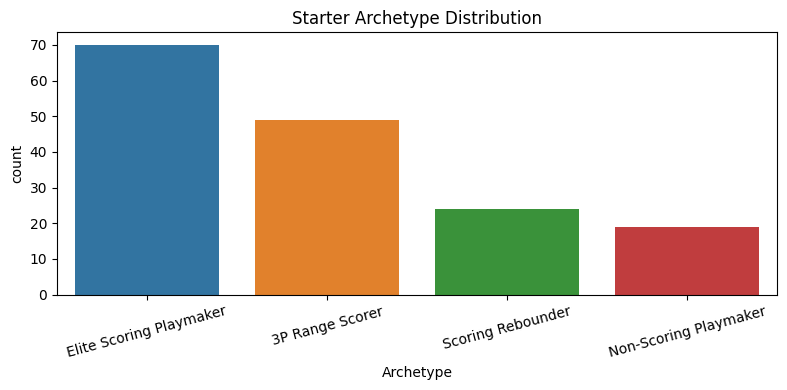

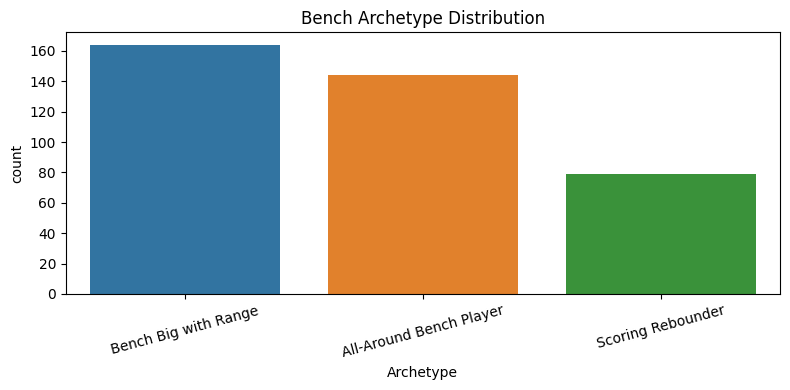

In [36]:
# Bar plot: Starter archetype counts
plt.figure(figsize=(8, 4))
sns.countplot(data=starters_df, x='Archetype', order=starters_df['Archetype'].value_counts().index)
plt.title('Starter Archetype Distribution')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Bar plot: Bench archetype counts
plt.figure(figsize=(8, 4))
sns.countplot(data=bench_df, x='Archetype', order=bench_df['Archetype'].value_counts().index)
plt.title('Bench Archetype Distribution')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

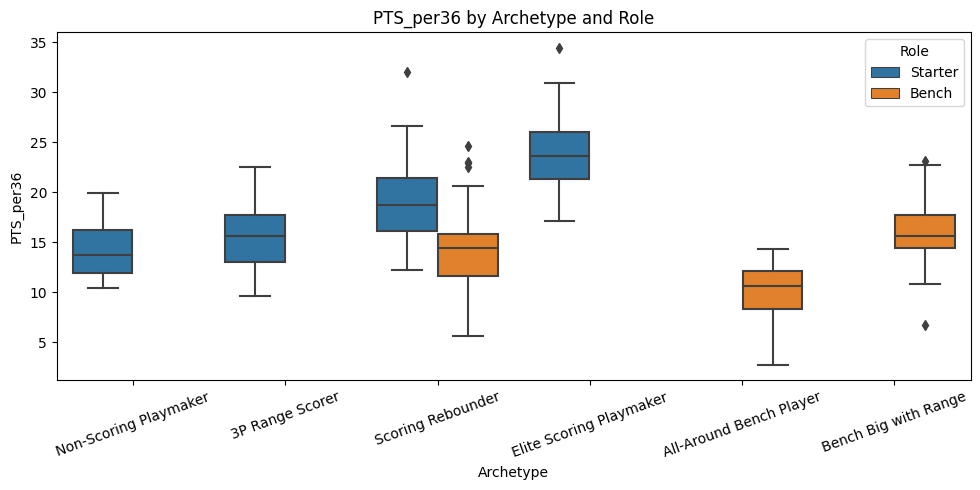

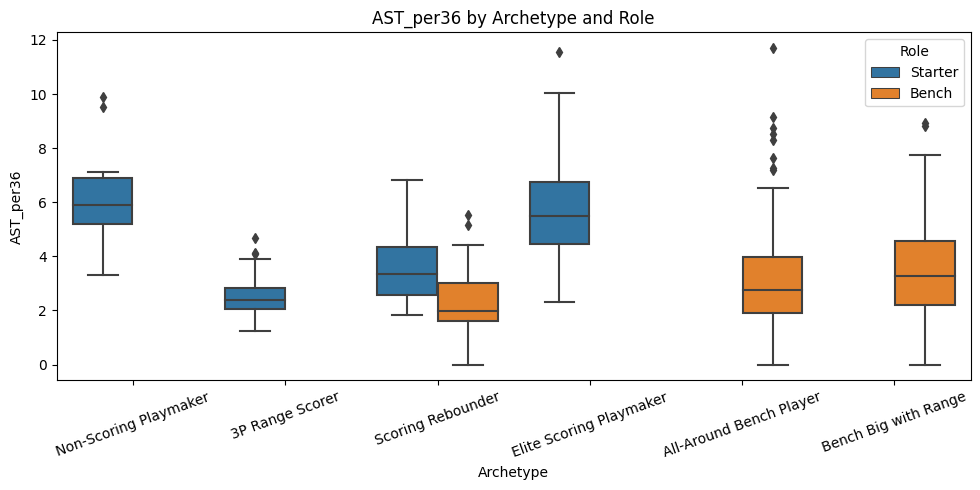

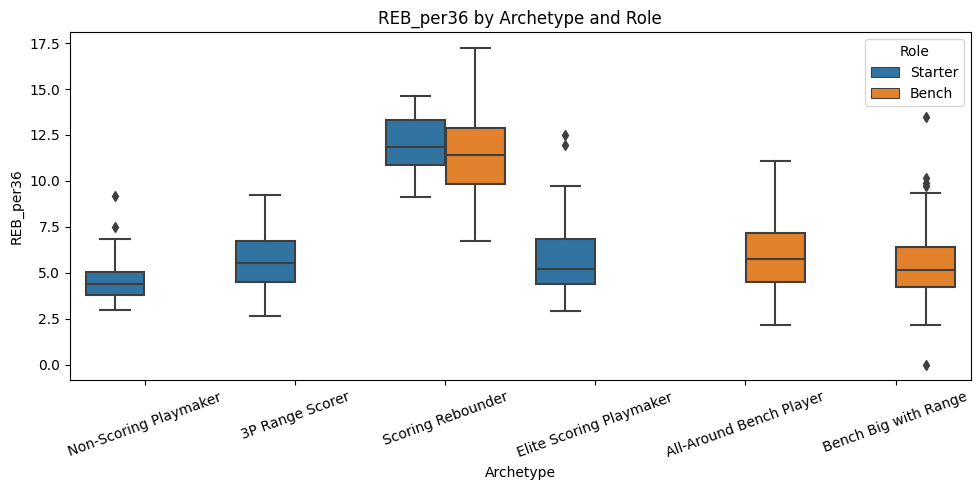

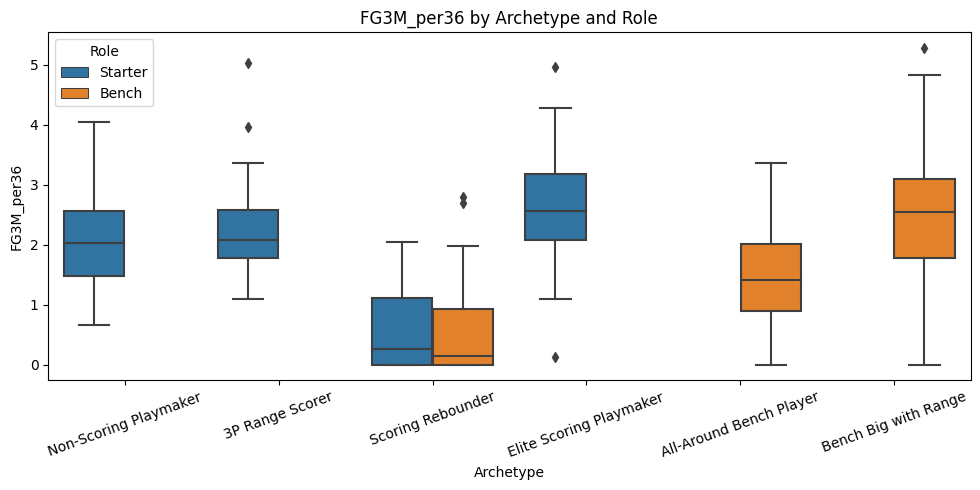

In [37]:
# Combine for boxplot analysis
starters_df['Role'] = 'Starter'
bench_df['Role'] = 'Bench'
combined_df = pd.concat([starters_df, bench_df])

# Select features to compare
features = ['PTS_per36', 'AST_per36', 'REB_per36', 'FG3M_per36']

# Create boxplots for each feature by archetype
for feat in features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=combined_df, x='Archetype', y=feat, hue='Role')
    plt.title(f'{feat} by Archetype and Role')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

# 🏁 Project Summary: Player Archetype Clustering

This project uses unsupervised machine learning (K-Means Clustering) on per-36 minute statistics from NBA players to identify distinct **player archetypes** based on performance and efficiency.

### 🔧 Features Used:
- Points per 36 minutes (PTS_per36)
- Assists per 36 minutes (AST_per36)
- Rebounds per 36 minutes (REB_per36)
- 3-Pointers Made per 36 (FG3M_per36)
- Efficiency score (EFF_score)

### 🔍 Methodology:
- Filtered players into **starters** vs. **bench** using minutes played.
- Applied KMeans clustering separately to each group.
- Used the elbow method and domain reasoning to choose `k=4` for starters and `k=3` for bench.
- Interpreted clusters using player profiles and performance metrics.

### 🧠 Final Archetypes Identified:

#### ⭐ Starters:
- **Non-Scoring Playmakers** (e.g. Haliburton, Jimmy Butler)
- **Elite Scoring Playmakers** (e.g. Jokic, SGA, Embiid)
- **Scoring Rebounders** (e.g. Giannis, AD, Sabonis)
- **Scorers with Deep 3P Range** (e.g. Lauri Markkanen, Michael Porter Jr.)

#### 🪑 Bench:
- **Scoring Rebounders** (e.g. Moses Brown, Jalen Smith)
- **All-Around Bench Players** (e.g. Trey Lyles, Torrey Craig)
- **Bench Bigs with Range** (e.g. Chris Boucher, Kevin Love)

### 📊 Insights:
- Archetypes provide a more intuitive way to group players than just position or minutes.
- This type of clustering can assist coaches, analysts, and scouts with matchups, roster construction, and role assignment.
- Visualizations support clear separation between archetypes in terms of scoring, assisting, and rebounding.